<a href="https://colab.research.google.com/github/jnrkufuor/apollo/blob/Ernest/notebooks/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Load Packagaes

In [2]:
!pip install squarify

import pandas as pd
import numpy as np
import math
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import statistics
from google.colab import drive
drive.mount('/content/drive')

tqdm.pandas()

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#2. Load data

##2.1 Load News Data

In [3]:
df_articles =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/googlenews1000.csv')

df_links = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_links_att2.csv')
print(len(df_links.index))
df_articles['datetime'] = pd.to_datetime(df_articles['datetime'])

375326


##2.2 Load Financial data

In [10]:
df_prices =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/price_corr.csv')
df_vol =  pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/volume_corr.csv')

df_finance_nds = pd.DataFrame(columns = ["from", "to", "weight"])

df_prices = df_prices.drop(df_prices.columns[0], axis=1)
df_prices.index = df_prices.columns

df_vol = df_vol.drop(df_vol.columns[0], axis=1)
df_vol.index = df_vol.columns

##2.3 Find Unique Pairs from Correlation Coefficient

In [26]:
# Get correlation pairs for Price and Volume
df_corr_price = df_prices[abs(df_prices) >= 0.0001].stack().reset_index()
df_corr_vol = df_vol[abs(df_vol) >= 0.0001].stack().reset_index()

#Take out lower triangle 
#for price
df_corr_price  = df_corr_price[df_corr_price['level_0'].astype(str)!=df_corr_price['level_1'].astype(str)]
df_corr_price['ordered-cols'] = df_corr_price.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#for volume
df_corr_vol  = df_corr_vol[df_corr_vol['level_0'].astype(str)!=df_corr_vol['level_1'].astype(str)]
df_corr_vol['ordered-cols'] = df_corr_vol.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#Remove duplicates and exclude self-correlated values
#for price
df_corr_price = df_corr_price.drop_duplicates(['ordered-cols'])
df_corr_price.reset_index(drop=True, inplace=True)
df_corr_price.drop(['ordered-cols'], axis=1, inplace=True)

#for volume
df_corr_vol = df_corr_vol.drop_duplicates(['ordered-cols'])
df_corr_vol.reset_index(drop=True, inplace=True)
df_corr_vol.drop(['ordered-cols'], axis=1, inplace=True)

#rename columns
df_corr_price.columns = {"from","to","correlation"}
df_corr_vol.columns = {"from","to","correlation"}

,from,to,correlation
0,AAPL,AMGN,0.301244
1,AAPL,AXP,0.365501
2,AAPL,BA,0.287836
3,AAPL,CAT,0.366761
4,AAPL,CRM,0.296335
...,...,...,...
430,V,WBA,0.292214
431,V,WMT,0.243581
432,VZ,WBA,0.290519
433,VZ,WMT,0.354435


#3. Subset data

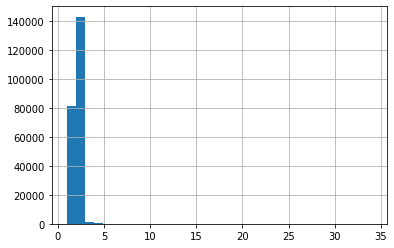

In [23]:
#date = '2020-03-26'
#df_links = df_links[df_links['date']==date]
df_links = df_links.groupby(['from', 'to']).size().reset_index()
df_links.rename(columns={0: 'count'}, inplace=True)
#df_links = df_links[df_links['count'] > 1] #uncomment if necessary
df_links.reset_index(drop=True, inplace=True)
df_links['weight'] = df_links['count']
df_links['weight'].hist(bins=max(df_links['weight']))

In [24]:
df_links[['from', 'to', 'weight']].sort_values('weight', ascending=False).head(10)

,from,to,weight
99582,Equitiescom,QuoteMedia,34
99497,Equitiescom,Equitiescom Newsdesk,34
99701,Equitiescom Newsdesk,QuoteMedia,34
90096,Dow Jones Industrial Average,Equitiescom Newsdesk,19
33144,BTC,Ethereum,19
33139,BTC,ETH,19
82168,DJIA,Equitiescom,19
33111,BTC,Bitcoin,19
90208,Dow Jones Industrial Average,QuoteMedia,19
43998,Bitcoin,ETH,19


##3.2 Subset Financial Nodes

In [40]:
statistics.mean(float(abs(df_corr_price["correlation"][0]))+abs(float(df_corr_price["correlation"][0])))

TypeError: ignored

In [34]:
import statistics #remove when done

for i in range(1,len(df_corr_price)):
    if(abs(df_corr_price["correlation"][i]) > 0.8 or abs(df_corr_vol["correlation"][i]) > 0.8):
       df_finance_nds.append(pd.DataFrame({[df_corr_vol["from"][i], df_corr_vol["to"][i], (mean(abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i])))]}))
    elif (abs(df_corr_price["correlation"][i]) < 0.8 and abs(df_corr_vol["correlation"][i]) < 0.8):
         if (abs(df_corr_price["correlation"][i]) >= 0.5 and abs(df_corr_vol["correlation"][i]) >= 0.5):
             df_finance_nds.append(pd.DataFrame({[df_corr_vol["from"][i], df_corr_vol["to"][i], (statistics.mean(abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i])))]}))
df_finance_nds.head(10)
#

TypeError: ignored

#4. Plot Edges

In [ ]:
# df_plot = df_links.sort_values('weight', ascending=False).head(150)
df_plot = df_links[df_links['weight']>6]
df_plot.reset_index(inplace=True, drop=True)

G_plot = nx.Graph()

for link in tqdm(df_plot.index):
  G_plot.add_edge(df_plot.iloc[link]['from'],
             df_plot.iloc[link]['to'],
             weight=df_plot.iloc[link]['weight'])

100%|██████████| 156/156 [00:00<00:00, 2258.36it/s]


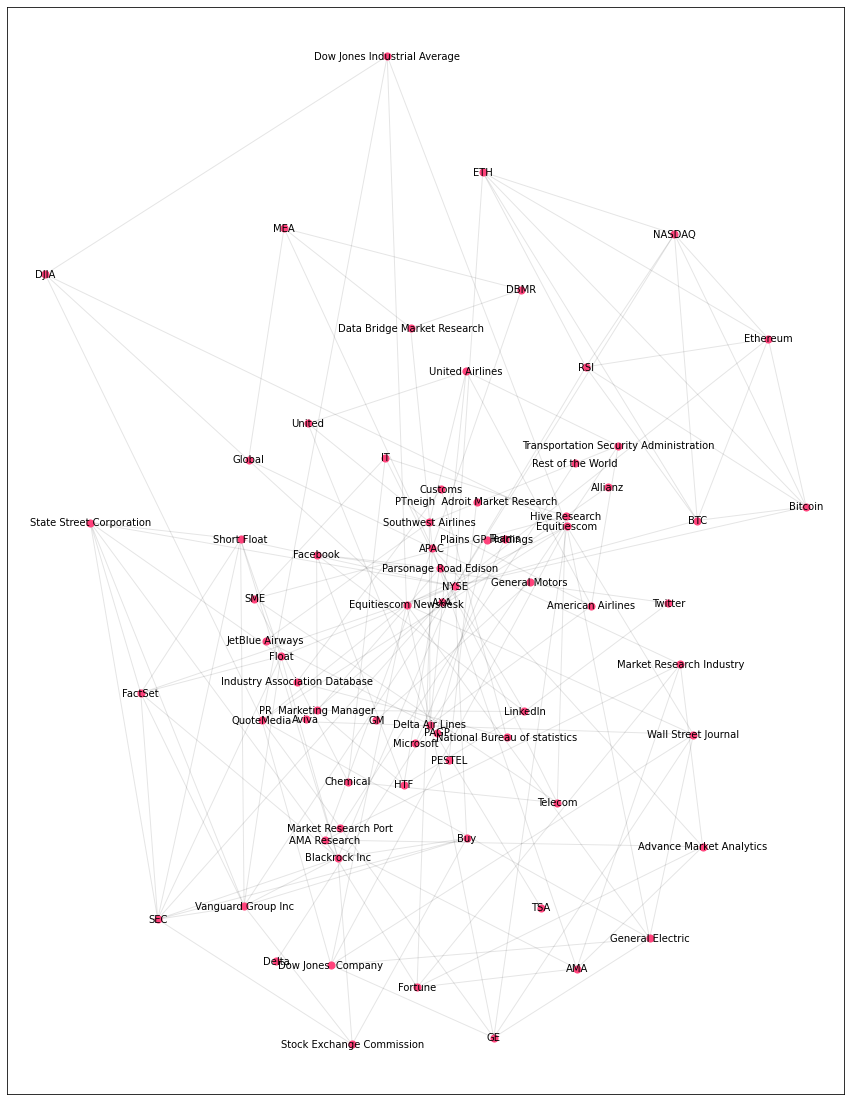

In [ ]:
pos = nx.kamada_kawai_layout(G_plot)
nodes = G_plot.nodes()
fig, axs = plt.subplots(1, 1, figsize=(15,20))

el = nx.draw_networkx_edges(G_plot, pos, alpha=0.1, ax=axs)
nl = nx.draw_networkx_nodes(G_plot, pos, nodelist=nodes, node_color='#FF427b', 
                            node_size=50, ax=axs)
ll = nx.draw_networkx_labels(G_plot, pos, font_size=10, font_family='sans-serif')

#5. Find Subgraphs

Build NetworkX graph


In [ ]:
df_link = df_links[df_links['weight']>6]
df_link.reset_index(inplace=True, drop=True)

G = nx.Graph()

for link in tqdm(df_link.index):
  G.add_edge(df_link.iloc[link]['from'],
             df_link.iloc[link]['to'],
             weight=df_link.iloc[link]['weight'])

100%|██████████| 156/156 [00:00<00:00, 2331.24it/s]


Find Centralities

100%|██████████| 71/71 [00:00<00:00, 20762.43it/s]


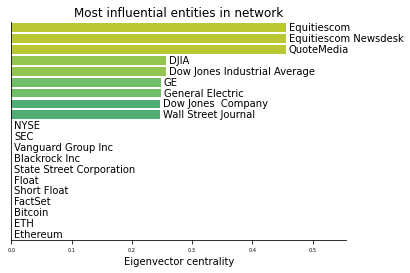

In [ ]:
nodes = []
eigenvector_cents = []
ec_dict = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')

for node in tqdm(G.nodes()):
  nodes.append(node)
  eigenvector_cents.append(ec_dict[node])

df_centralities = pd.DataFrame(data={'entity': nodes,
                                     'eigenvector': eigenvector_cents})

df_cent_top = df_centralities.sort_values('eigenvector', ascending=False).head(20)
df_cent_top.reset_index(inplace=True, drop=True)

g = sns.barplot(data=df_cent_top,
            x='eigenvector',
            y='entity',
            dodge=False,
            orient='h',
            hue='eigenvector',
            palette='viridis',)

g.set_yticks([])
g.set_title('Most influential entities in network')
g.set_xlabel('Eigenvector centrality')
g.set_ylabel('')
g.set_xlim(0, max(df_cent_top['eigenvector'])+0.1)
g.legend_.remove()
g.tick_params(labelsize=5)

for i in df_cent_top.index:
    g.text(df_cent_top.iloc[i]['eigenvector']+0.005, i+0.25, df_cent_top.iloc[i]['entity'])

sns.despine()
g.get_figure().savefig('cent_plot.png', dpi=1000)

#6. Cliques

Finding the optimal number


In [ ]:
from networkx.algorithms.community.kclique import k_clique_communities

100%|██████████| 28/28 [00:00<00:00, 1287.65it/s]


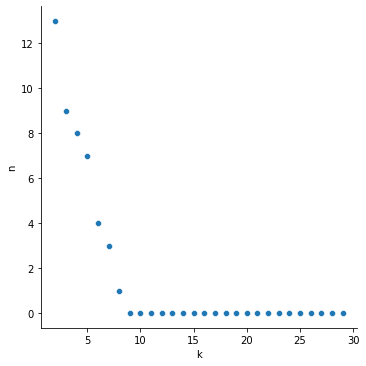

In [ ]:
clique_sizes = range(2, 30)
n_cliques = []
0
for k in tqdm(clique_sizes):
  n_cliques.append(len(list(k_clique_communities(G, k))))

df_relplot = pd.DataFrame(data={'k': clique_sizes,
                                'n': n_cliques})

sns.relplot(data=df_relplot,
            x='k',
            y='n')

In [ ]:
cliques = list(k_clique_communities(G, 4))

Find centralities in cliques

In [ ]:
eigenvector_cents = []
entities = []
clique_ids = []

for id, clique in enumerate(cliques):
  sg = G.subgraph(list(clique))

  nodes = sg.nodes()

  clique_ids.extend(np.repeat(id, len(nodes)))
  entities.extend(nodes)

  ec_dict = nx.eigenvector_centrality(sg, max_iter=1000, weight='weight')

  for entity in nodes:
    eigenvector_cents.append(ec_dict[entity])

df_cliques = pd.DataFrame(data={
    'clique': clique_ids,
    'entity': entities,
    'centrality': eigenvector_cents
})

df_cliques

,clique,entity,centrality
0,0,APAC,0.557345
1,0,DBMR,0.435162
2,0,Data Bridge Market Research,0.435162
3,0,MEA,0.557345
4,1,Telecom,0.507049
5,1,Chemical,0.332474
6,1,IT,0.497943
7,1,Hive Research,0.369416
8,1,SME,0.497943
9,2,Vanguard Group Inc,0.387290


In [ ]:
col_pal = {0: '#F1E3F3',
           1: '#A0DDFF',
           2: '#FF8A5B',
           3: '#74D3AE',
           4: '#93B7BE',
           5: '#D1B1CB',
           6: '#BAF2BB',
           7: '#FFA69E',
           8: '#97EAD2',
           9: '#34E4EA',
           10: '#B95F89',
           99:'#828A95'}

Plot Cliques

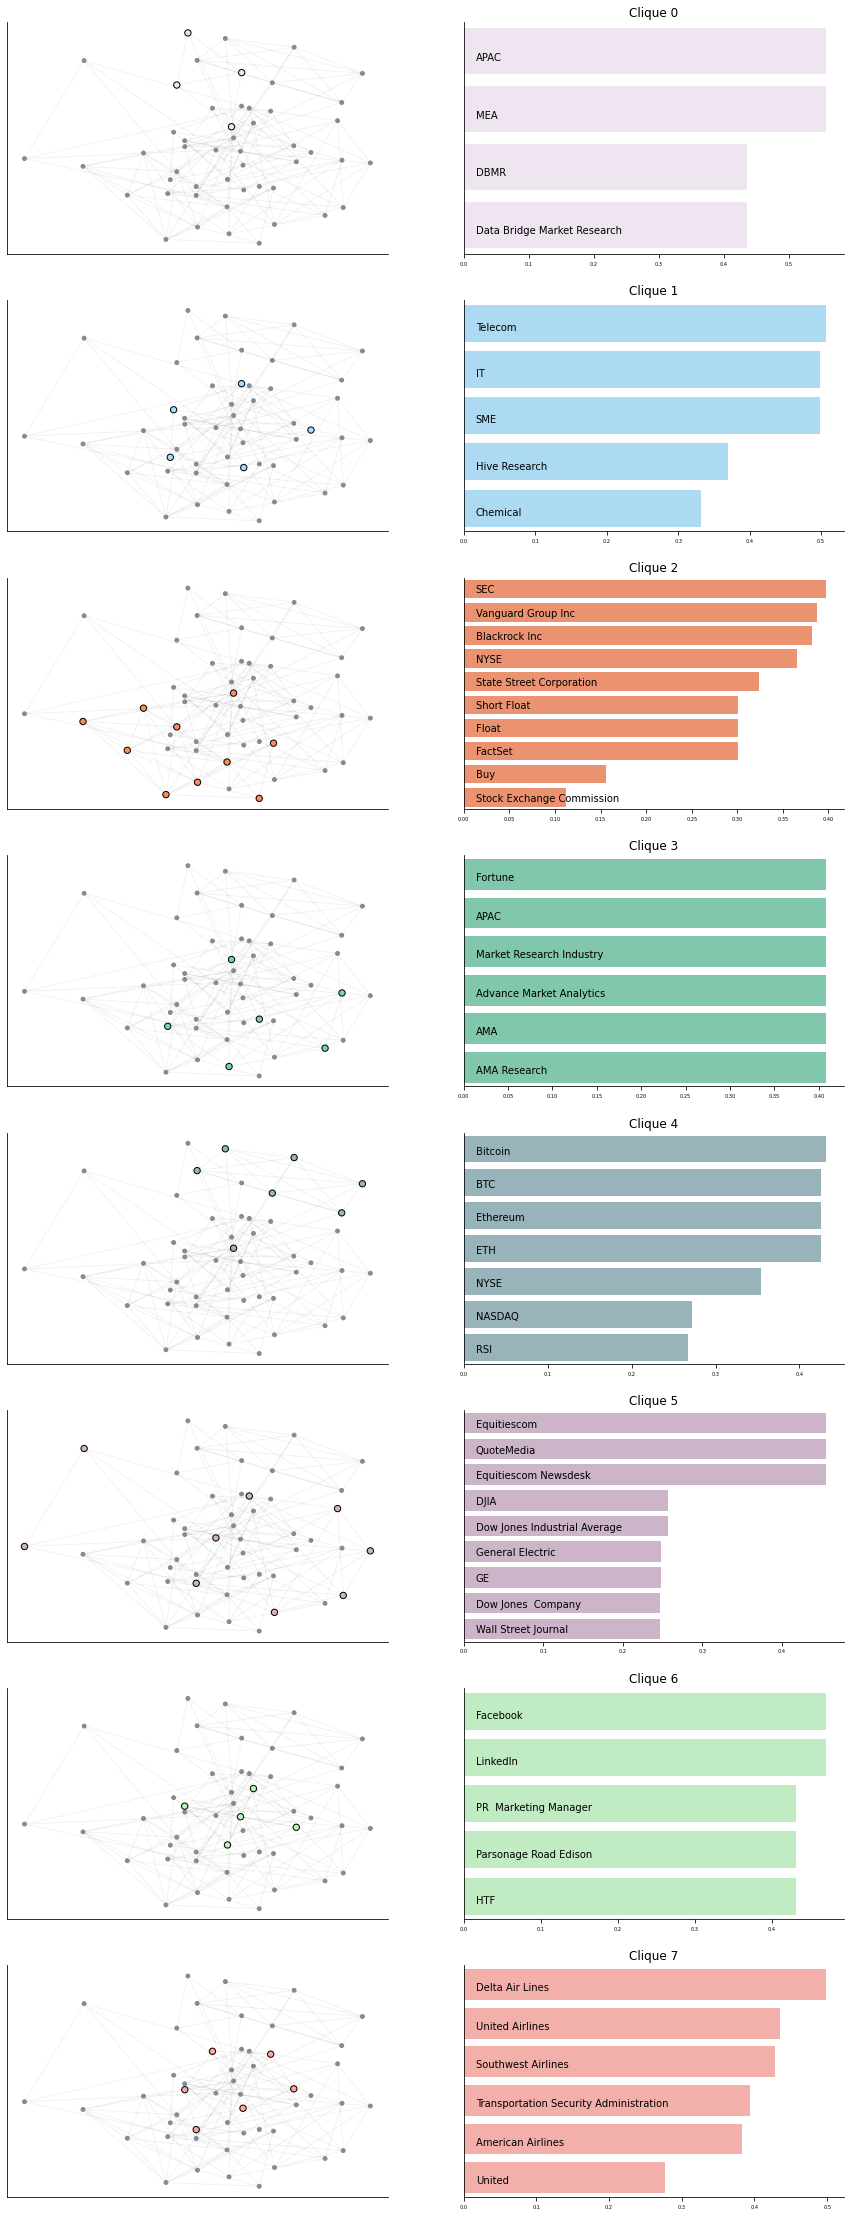

In [ ]:
G_clique = G.subgraph(df_cliques['entity'].unique())
pos = nx.kamada_kawai_layout(G_clique)
nodes = G_clique.nodes()


fig, axs = plt.subplots(max(df_cliques['clique'])+1, 2, figsize=(15,40))

for clique in range(max(df_cliques['clique'])+1):
  node_colors = [col_pal[clique] if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]
  sizes = [40 if node in df_cliques[df_cliques['clique']==clique]['entity'].values else 15 for node in nodes]
  edge_colors = ['black' if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]

  ec = nx.draw_networkx_edges(G_clique, pos, alpha=0.05, ax=axs[clique, 0])
  nc = nx.draw_networkx_nodes(G_clique, pos, nodelist=nodes, node_color=node_colors, 
                              node_size=sizes, ax=axs[clique, 0],
                              edgecolors=edge_colors)
  
  df_clique_ind = df_cliques[df_cliques['clique']==clique]
  df_clique_ind = df_clique_ind.sort_values('centrality', ascending=False).head(15)
  df_clique_ind.reset_index(inplace=True, drop=True)

  g = sns.barplot(data=df_clique_ind,
              x='centrality',
              y='entity',
              hue='clique',
              palette=col_pal,
              dodge=False,
              orient='h',
              ax=axs[clique, 1])
  
  g.set_yticks([])
  g.set_title(f'Clique {clique}')
  g.set_xlabel('')
  g.set_ylabel('')
  g.legend_.remove()
  g.tick_params(labelsize=5)

  for i in df_clique_ind.index:
    g.text(max(df_clique_ind['centrality'])/30, i+0.15, df_clique_ind.iloc[i]['entity'])
  

sns.despine()

fig.savefig('clique_plot.png', dpi=1000)